In [368]:
import pandas as pd 
import numpy as np 
import pybaseball as pyball
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

pd.set_option('display.max_columns', None)  # Show all columns


### THE GRAPHS 

In this notebook I want to mess around with different ways to present a pitchers arsenal. I want to work on displaying a pitchers arsenal, with the goal of understanding a pitchers strengths and weakness. 

- pitch selection 
- velocity 
- location 
- consistency


In [369]:
#The data 

#Set whatever date range you want!! 
start = '2024-03-20'
end = '2024-9-30'

#Player Name
last = 'Eflin'
first = 'Zach'

#Get Player ID
id = int(pyball.playerid_lookup(last, first)['key_mlbam'].values[0])

pbp_data = pyball.statcast_pitcher(start, end, id)
php_data = pbp_data[pbp_data['game_type'] == 'R']
pbp_data['count'] = pbp_data['balls'].astype(str) + '-' + pbp_data['strikes'].astype(str)

pbp_data.head(5)

Gathering Player Data


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle,count
0,FC,2024-09-25,88.9,-2.37,5.80,"Eflin, Zach",669224,621107,walk,ball,NaN,NaN,NaN,NaN,11.0,Austin Wells walks. Aaron Judge to 2nd.,R,L,R,NYY,BAL,B,NaN,NaN,3,1,2024,0.11,0.67,-1.08,3.58,NaN,NaN,592450.0,2,5,Bot,NaN,NaN,NaN,NaN,NaN,NaN,2.971185,-129.589476,-0.845252,0.639171,25.182412,-24.653830,3.47,1.60,NaN,NaN,NaN,89.8,2189.0,6.6,745690,543510,663624,676059,602104,683002,681297,656775,623993,53.88,NaN,0.689131,0.7,1.0,0.0,0.0,NaN,50,5,Cutter,3,8,3,8,8,3,3,8,Infield shade,Standard,210.0,0.011,0.152,NaN,NaN,NaN,-0.152,NaN,-5,-5,0.053,0.053,30,24,30,25,3,2,6.0,1.0,7.0,1.0,2.19,-0.11,0.11,25.7,3-1
1,CH,2024-09-25,87.9,-2.24,5.85,"Eflin, Zach",669224,621107,NaN,ball,NaN,NaN,NaN,NaN,14.0,Austin Wells walks. Aaron Judge to 2nd.,R,L,R,NYY,BAL,B,NaN,NaN,2,1,2024,-1.34,0.13,0.43,1.03,NaN,NaN,592450.0,2,5,Bot,NaN,NaN,NaN,NaN,NaN,NaN,9.329778,-127.670315,-5.897741,-16.583509,26.030741,-29.678778,3.47,1.57,NaN,NaN,NaN,88.8,1892.0,6.9,745690,543510,663624,676059,602104,683002,681297,656775,623993,53.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,4,Changeup,3,8,3,8,8,3,3,8,Infield shade,Standard,244.0,0.000,0.078,NaN,NaN,NaN,-0.078,NaN,-5,-5,0.053,0.053,30,24,30,25,3,2,6.0,1.0,7.0,1.0,2.83,1.34,-1.34,29.4,2-1
2,FF,2024-09-25,91.4,-2.29,5.79,"Eflin, Zach",669224,621107,NaN,ball,NaN,NaN,NaN,NaN,11.0,Austin Wells walks. Aaron Judge to 2nd.,R,L,R,NYY,BAL,B,NaN,NaN,1,1,2024,-0.66,1.12,-0.94,2.91,NaN,NaN,592450.0,2,5,Bot,NaN,NaN,NaN,NaN,NaN,NaN,4.871336,-132.952630,-3.776810,-8.836707,29.827299,-18.357870,3.55,1.68,NaN,NaN,NaN,92.0,2172.0,6.8,745690,543510,663624,676059,602104,683002,681297,656775,623993,53.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,3,4-Seam Fastball,3,8,3,8,8,3,3,8,Infield shade,Standard,231.0,0.000,0.050,NaN,NaN,NaN,-0.050,NaN,-5,-5,0.053,0.053,30,24,30,25,3,2,6.0,1.0,7.0,1.0,1.63,0.66,-0.66,25.2,1-1
3,FC,2024-09-25,88.4,-2.29,5.75,"Eflin, Zach",669224,621107,NaN,swinging_strike,NaN,NaN,NaN,NaN,1.0,Austin Wells walks. Aaron Judge to 2nd.,R,L,R,NYY,BAL,S,NaN,NaN,1,0,2024,0.00,0.70,-0.34,3.20,NaN,NaN,592450.0,2,5,Bot,NaN,NaN,NaN,NaN,NaN,NaN,4.774309,-128.767122,-1.638702,-0.929811,25.159661,-24.214937,3.47,1.65,NaN,NaN,NaN,89.4,2155.0,6.7,745690,543510,663624,676059,602104,683002,681297,656775,623993,53.81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,2,Cutter,3,8,3,8,8,3,3,8,Infield shade,Standard,209.0,0.000,-0.048,72.9,6.5,NaN,0.048,NaN,-5,-5,0.053,0.053,30,24,30,25,3,2,6.0,1.0,7.0,1.0,2.20,0.00,0.00,26.3,1-0
4,FC,2024-09-25,88.8,-2.43,5.79,"Eflin, Zach",669224,621107,NaN,ball,NaN,NaN,NaN,NaN,11.0,Austin Wells walks. Aaron Judge to 2nd.,R,L,

In [370]:
#Pitch colours need to be consistent so the pies will be easier to read and compare 
pitch_colors = {
    # Fastballs
    "4-Seam Fastball": "#FF007D",
    "Fastball": "#FF007D",
    "Sinker": "#98165D",
    "Cutter": "#BE5FA0",

    # Offspeed
    "Changeup": "#F79E70",
    "Splitter": "#FE6100",
    "Screwball": "#F08223",
    "Forkball": "#FFB000",

    # Sliders
    "Slider": "#67E18D",
    "Sweeper": "#1BB999",
    "Slurve": "#376748",

    # Curveballs
    "Knuckle Curve": "#311D8B",
    "Curveball": "#3025CE",
    "Slow Curve": "#274BFC",
    "Eephus": "#648FFF",

    # Others
    "Knuckleball": "#867A08",
    "Pitch Out": "#472C30",
    "Unknown": "#9C8975"
}

### Pitch Distribution! 

In order to display the distribution of a players pitch I will use pie charts. This should give an idea of what pitches are most likely to be thrown. 

In [371]:
#Pitch distribution
pitch_counts = pbp_data['pitch_name'].value_counts().to_dict()

pitch_counts_LHB = pbp_data[pbp_data['stand'] == 'L']
pitch_counts_LHB = pitch_counts_LHB['pitch_name'].value_counts().to_dict()

pitch_counts_RHB = pbp_data[pbp_data['stand'] == 'R']
pitch_counts_RHB = pitch_counts_RHB['pitch_name'].value_counts().to_dict()

In [372]:
pitch_counts

{'Sinker': 706,
 'Cutter': 691,
 'Curveball': 461,
 'Sweeper': 231,
 '4-Seam Fastball': 205,
 'Changeup': 148,
 'Slider': 5}

In [373]:
pitch_counts_LHB

{'Cutter': 453,
 'Sinker': 242,
 'Curveball': 223,
 'Changeup': 140,
 '4-Seam Fastball': 124,
 'Sweeper': 39}

In [374]:
pitch_counts_RHB

{'Sinker': 464,
 'Cutter': 238,
 'Curveball': 238,
 'Sweeper': 192,
 '4-Seam Fastball': 81,
 'Changeup': 8,
 'Slider': 5}

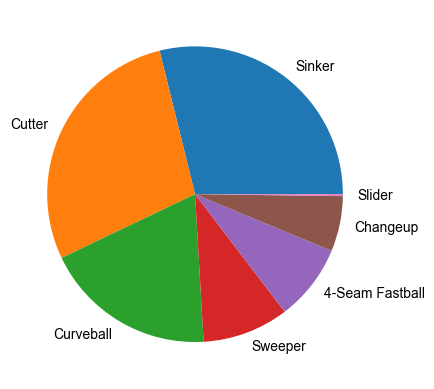

In [375]:
#PIE CHART 

plt.pie(pitch_counts.values(), labels = pitch_counts.keys())
plt.show()

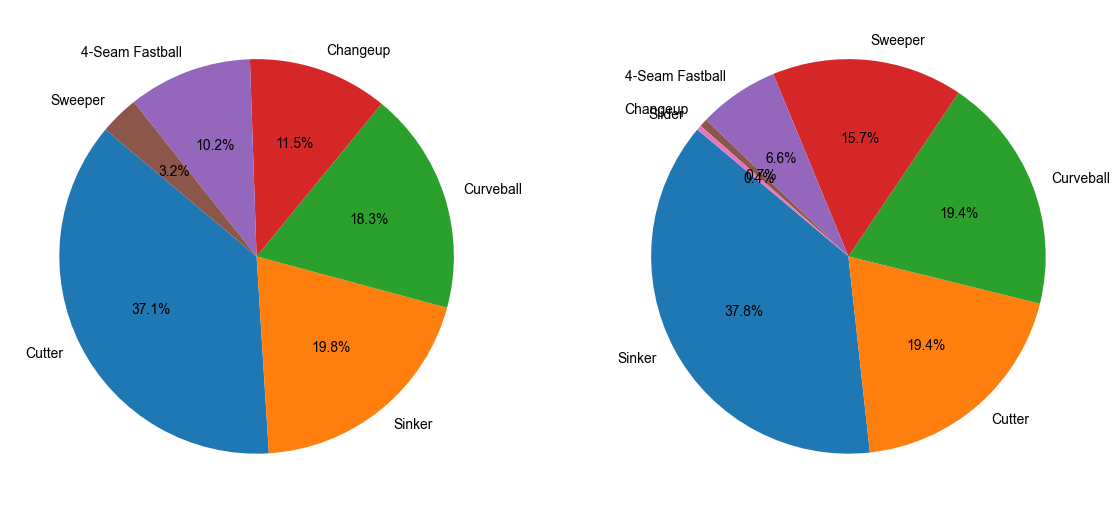

In [376]:
#Compare RHB vs LHB 

fig, axes = plt.subplots(1,2, figsize=(14,7))

axes[0].pie(
    pitch_counts_LHB.values(),
    labels = pitch_counts_LHB.keys(),
    autopct = '%1.1f%%',
    startangle = 140
)
axes[1].pie(
    pitch_counts_RHB.values(),
    labels = pitch_counts_RHB.keys(),
    autopct = '%1.1f%%',
    startangle = 140
)

plt.show()
#kinda sloppy and annoying to makes changes twice, lets see if we can use a loop to make the code cleaner.


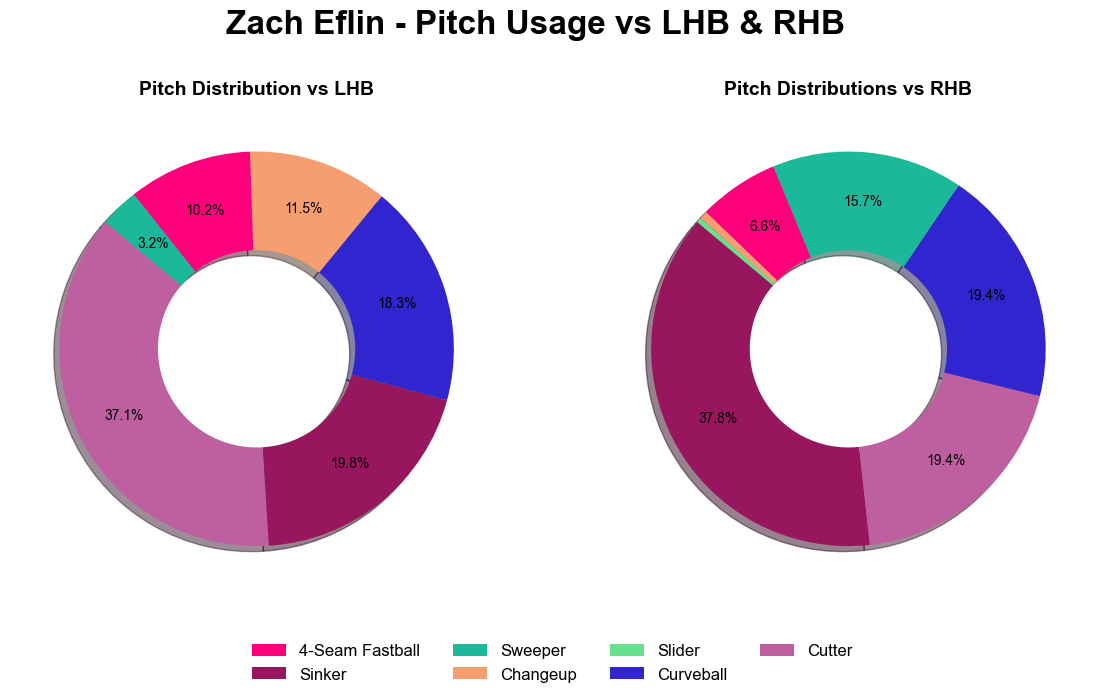

In [377]:
batter_splits = [pitch_counts_LHB, pitch_counts_RHB]
titles = ['Pitch Distribution vs LHB', 'Pitch Distributions vs RHB']

#change font for fun
plt.rcParams['font.family'] = 'Arial'


def autopct_threshold(pct, threshold=2):
    return f'{pct:.1f}%' if pct > threshold else ''

fig, axes = plt.subplots(1,2, figsize = (14,7))

for ax, pitch_data, title in zip(axes, batter_splits, titles):

    labels = list(pitch_data.keys())
    colours = [pitch_colors.get(pitch, pitch_colors) for pitch in labels]

    ax.pie(
        pitch_data.values(), 
        startangle = 140,
        autopct =lambda pct: autopct_threshold(pct, threshold=3),
        labeldistance=1.1,
        colors = colours,
        pctdistance = 0.75,
        wedgeprops=dict(width=0.5), 
        shadow = True   
    )
    ax.set_title(title, fontsize = 14, fontweight='bold')


# Get all unique pitch types used across both LHB and RHB
all_pitches = set(pitch_counts_LHB.keys()) | set(pitch_counts_RHB.keys())
legend_elements = [
    Patch(facecolor = pitch_colors.get(pitch, pitch_colors), label=pitch)
    for pitch in all_pitches
]

# Add the legend to the figure (not one of the axes)
fig.legend(
    handles = legend_elements,
    loc='lower center',  
    ncol = 4,              
    fontsize = 12,
    frameon = False
)

main_title = first + ' ' + last + ' - Pitch Usage vs LHB & RHB' 
fig.suptitle(main_title, fontsize = 24, fontweight = 'bold')
plt.show()


Amazing! I quite like how the pie charts are looking so far. The next steps to make this even more helpful is to add a sort of filter. I want to be able to select the count in order to see how a pitcher might change their attack based on being behind or ahead in the count and so on. 

I will now need to convert my code above into a plotting function. This will allow me to use some sort of GUI to use a drop down menu to be one of the inputs of the function, in this case the count. The count input will then be used to filter the data shown in the graph. 

In [378]:
#Filter data based on count
def count_filter(pbp_data, counts): 
    #Count filters, can change later if needed. 
    hitters_count = ['1-0', '2-0', '3-1', '3-0']
    pitchers_count = ['1-2', '0-2']
    even_count = ['0-0', '1-1']

    print("hello")
    if counts == 'All':
        return pbp_data
    elif counts == 'Ahead':
        return pbp_data[pbp_data['count'].isin(pitchers_count)]
    elif counts == 'Behind': 
        return pbp_data[pbp_data['count'].isin(hitters_count)]
    elif counts == 'Even': 
        return pbp_data[pbp_data['count'].isin(even_count)]
    else:
        return pbp_data[pbp_data['count'] == counts]
    

#Percent for pie slice
def autopct_threshold(pct, threshold=2):
    return f'{pct:.1f}%' if pct > threshold else ''

#Return total amount if pitch type thrown
def pitchSums(pbp_data, stand = None):
    if stand == None: 
        return pbp_data['pitch_name'].value_counts().to_dict()
    else:
        pitches = pbp_data[pbp_data['stand'] == stand]
        return pitches['pitch_name'].value_counts().to_dict()


#Plot two pie charts showing batter spits 
def plot_pitchDist(data, count):

    data = count_filter(pbp_data = data, counts = count)
    batter_splits = [pitchSums(data, stand = 'L'), pitchSums(data, stand = 'R')]

    
    titles = ['Pitch Distribution vs LHB', 'Pitch Distributions vs RHB']

    #change font for fun
    plt.rcParams['font.family'] = 'Arial'

    fig, axes = plt.subplots(1,2, figsize = (14,7))

    for ax, pitch_data, title in zip(axes, batter_splits, titles):

        labels = list(pitch_data.keys())
        colours = [pitch_colors.get(pitch, pitch_colors) for pitch in labels]

        ax.pie(
            pitch_data.values(), 
            startangle = 140,
            autopct =lambda pct: autopct_threshold(pct, threshold=3),
            labeldistance=1.1,
            colors = colours,
            pctdistance = 0.75,
            wedgeprops=dict(width=0.5), 
            shadow = True   
        )
        ax.set_title(title, fontsize = 14, fontweight='bold')

    #Display count
    fig.text(
        0.5,        
        0.88,       
        f"{count} counts",  
        ha='center',
        fontsize=18,
        fontweight='bold'
    )


    # Get all unique pitch types used across both LHB and RHB
    all_pitches = set(pitch_counts_LHB.keys()) | set(pitch_counts_RHB.keys())
    legend_elements = [
        Patch(facecolor = pitch_colors.get(pitch, pitch_colors), label=pitch)
        for pitch in all_pitches
    ]

    # Add the legend to the figure (not one of the axes)
    fig.legend(
        handles = legend_elements,
        loc='lower center',  
        ncol = 4,              
        fontsize = 12,
        frameon = False
    )

    main_title = first + ' ' + last + ' - Pitch Usage vs LHB & RHB' 
    fig.suptitle(main_title, fontsize = 24, fontweight = 'bold')
    plt.show()

hello


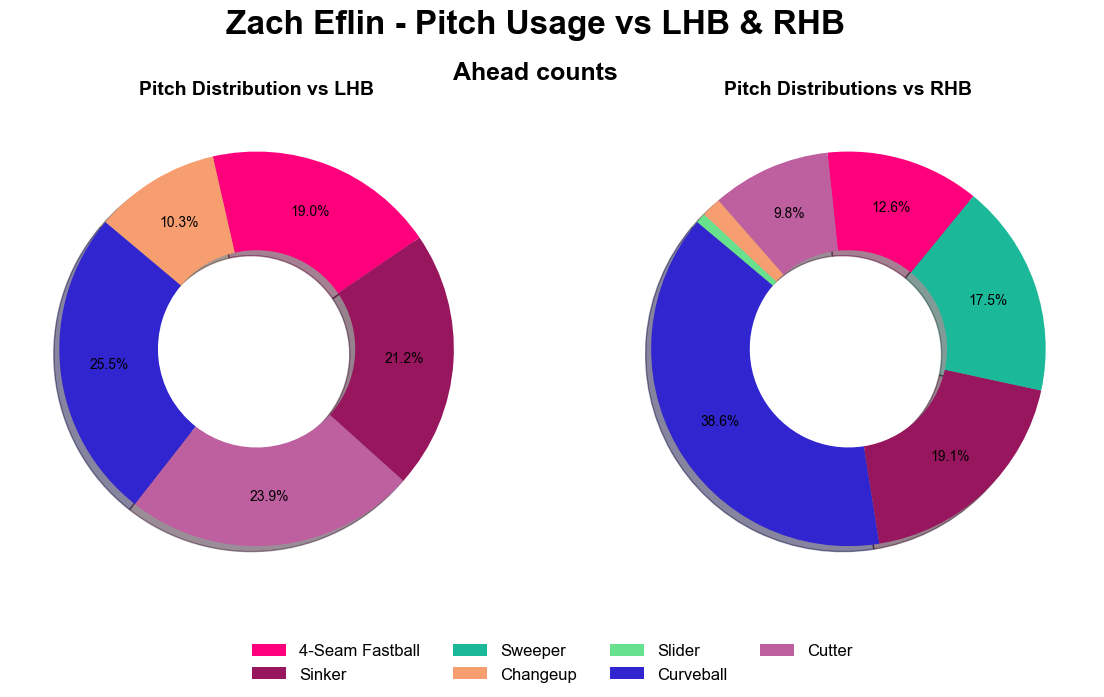

In [379]:
plot_pitchDist(pbp_data, count = 'Ahead')

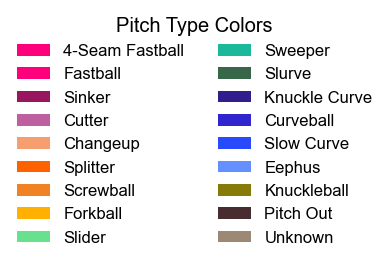

In [380]:
# Create dummy figure
fig, ax = plt.subplots(figsize=(4, 2))

# Hide axes
ax.axis('off')

# Create a list of legend patches using the pitch_colors
legend_handles = [Patch(facecolor=color, label=pitch) for pitch, color in pitch_colors.items()]

# Add the legend
legend = ax.legend(
    handles=legend_handles,
    title='Pitch Type Colors',
    loc='center',
    fontsize='large',
    title_fontsize='x-large',
    frameon=False,
    ncol=2 
)

plt.show()

### Pitch Velocity 

Next up is VELOCITY! I want to display the velocity of each pitch type as well as the range it appears in. To do so I will try a few different options and see what I like best. 

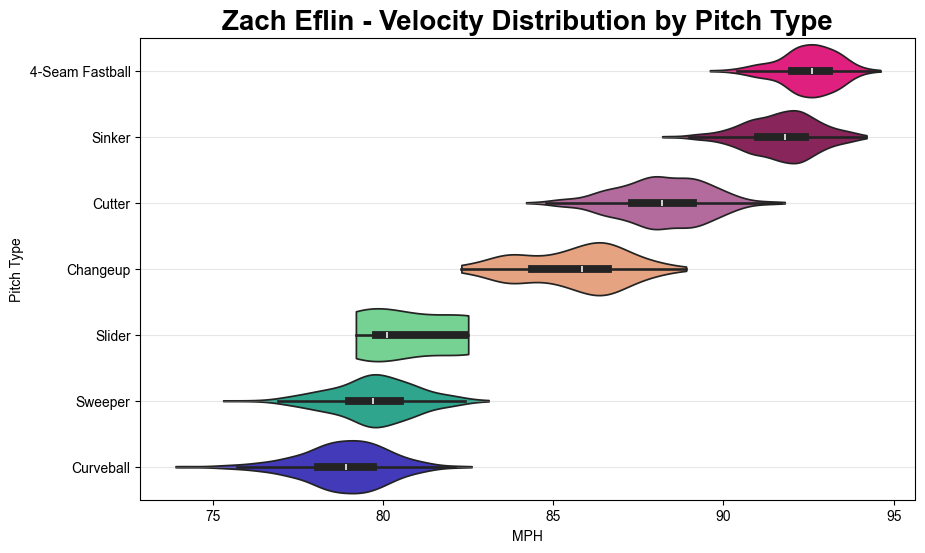

In [381]:
#Violin Plot!

plt.figure(figsize=(10,6))

#change font for fun
plt.rcParams['font.family'] = 'Arial'

order = pbp_data.groupby('pitch_name')['release_speed'].mean().sort_values(ascending=False).index.tolist()


sns.violinplot(
    data = pbp_data,
    y = 'pitch_name',
    x = 'release_speed',
    hue = 'pitch_name',
    palette= pitch_colors,
    legend= False,
    order=order,
    cut = 0,
    density_norm='area'
)


plt.title(first +  " " + last + " - Velocity Distribution by Pitch Type", fontsize = "20", fontweight = 'bold')
plt.ylabel('Pitch Type')
plt.xlabel('MPH')
plt.grid(axis='y', alpha = 0.3)

plt.show()

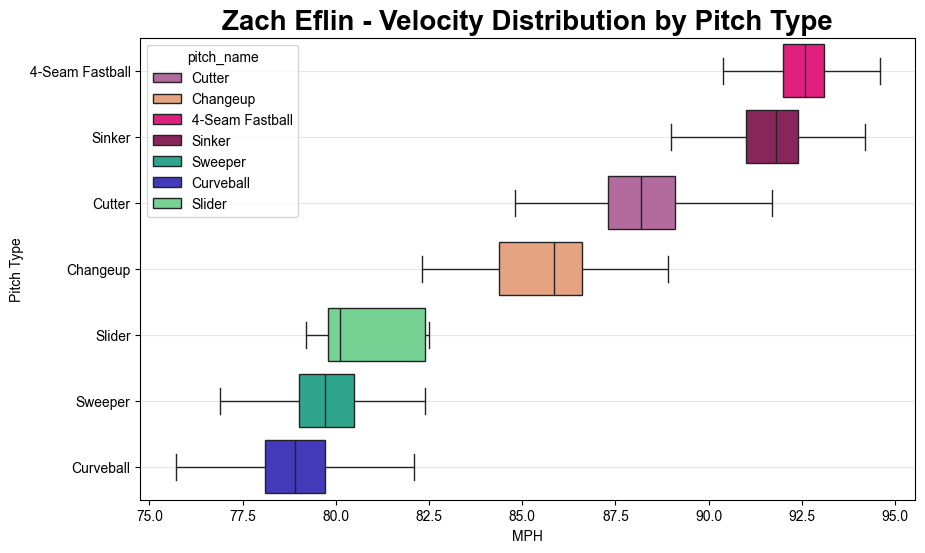

In [382]:
#Box Plot! 
plt.figure(figsize=(10,6))

order = pbp_data.groupby('pitch_name')['release_speed'].mean().sort_values(ascending=False).index.tolist()


sns.boxplot(
    data = pbp_data, 
    y = 'pitch_name',
    x = 'release_speed',
    hue= 'pitch_name',
    palette=pitch_colors, 
    order = order,
    showfliers = False
)

plt.title(first +  " " + last + " - Velocity Distribution by Pitch Type", fontsize = "20", fontweight = 'bold')
plt.ylabel('Pitch Type')
plt.xlabel('MPH')
plt.grid(axis='y', alpha = 0.3)

plt.show()

### Movement Profile! 


In [383]:
def movementProfile(pbp_data):
    plt.rcParams['font.family'] = 'Arial'
    plt.figure(figsize = (6.5,6.5))

    ax = plt.gca()

    for spine in ax.spines.values():
        spine.set_visible(False)

    # Add concentric rings
    for radius in [0.5, 1.0, 1.5, 2.0, 2.5]:
        circle = plt.Circle(
            (0, 0),              
            radius,            
            color='gray',
            fill=False,
            linestyle='dotted',
            linewidth=0.8,
            alpha=0.4,
            zorder=0
        )
        ax.add_patch(circle)

    sns.scatterplot(
        data=pbp_data,
        x = 'pfx_x',
        y = 'pfx_z',
        hue='pitch_name',
        palette=pitch_colors,
        s=50,
        edgecolor = 'black'
    )

    plt.title(first + ' ' + last + ' - Movement Profile',
              fontsize = 20,
              fontweight = 'bold',
              pad = 20) 
    
    numPitches = len(pbp_data['pitch_name'].unique())
    if numPitches <=2: 
        anchor_x = 0.75
    elif numPitches == 3: 
        anchor_x = 0.85
    else:
        anchor_x = 1

    plt.legend(
        title = 'Pitch Type',
        ncol = 4,
        bbox_to_anchor = (anchor_x,-0.13)
        )
    
    #Center axis
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.axvline(0, color='gray', linestyle='--', linewidth=1)
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.show()


    

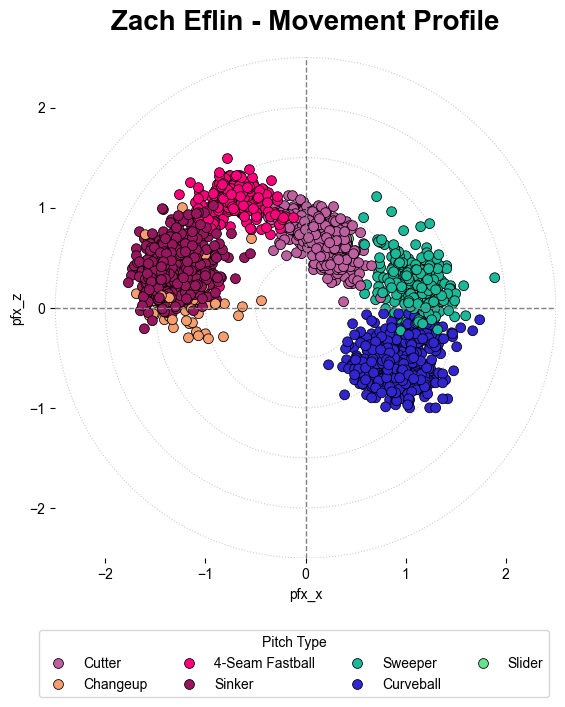

In [384]:
movementProfile(pbp_data)

### The Tunnel Effect! 

The next few graphs will focus on visualizing a pitchers tunneling abilities. So what it tunnelling? This is when a pitcher does a good job of making pitchers look the same in the first 20-30 feet, then having the pitches break in different directions, making it difficult for the hitter to tell what pitch is coming. 

How can we visualize this? 

To start I'm gonna take a look at the pitchers release point as we have access to this in our data set. It is the start of the tunnel, if all pitches come from the same spot, thats a good sign. 



In [385]:
def releasePlot(pbp_datadata):
    plt.rcParams['font.family'] = 'Arial'
    plt.figure(figsize = (8,8))


    sns.scatterplot(
        data=pbp_data,
        x = 'release_pos_x',
        y = 'release_pos_z',
        hue='pitch_name',
        palette=pitch_colors,
        s=50,
        edgecolor = 'black'
    )
    plt.xlim(-6,6)
    plt.ylim(0,8)

    plt.title(first + ' ' + last + ' - Release Point by Pitch Type',fontsize = 20, fontweight = 'bold') 
    plt.legend(
        title = 'Pitch Type',
        loc = 'lower center',
        ncol = 2
        )

    plt.gca().set_aspect('equal', adjustable='box')
    plt.gca().set_facecolor('#f9f9f9')
    plt.grid(True, linestyle='--', alpha=0.3)

    plt.xticks(
        ticks = plt.xticks()[0],
        labels = [f"{abs(int(x))}ft" for x in plt.xticks()[0]]
    )
    plt.yticks(
        ticks = plt.yticks()[0][2::2],
        labels = [f"{int(y)}ft" for y in plt.yticks()[0][2::2]]
    )


    plt.xlabel("")
    plt.ylabel("")


    plt.show()


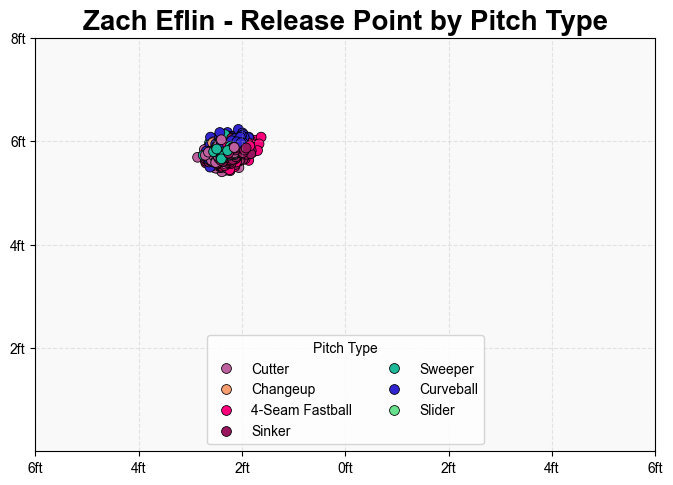

In [386]:
releasePlot(pbp_data)